# Capstone Project --- Analysis of Restaurants in Paris

*Author: Zinan Lin*

Details of introduction and conclusion can be found in the reopsitary of this notebook

## Part 0: Import libraries

Import all libraries here

In [767]:
import numpy as np
import pandas as pd
import requests

# data visualization modules
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Part 1: Load and Clean Data 

### 1.1 Load the name of all michelin starred restaurants in Paris

In [768]:
df_michelin = pd.read_excel('michelinstar.xlsx', index_col=None, header=None, names=['Name', 'Star'])
df_michelin.head()

,Name,Star
0,Alain Ducasse au Plaza Athénée,3
1,Alléno Paris au Pavillon Ledoyen,3
2,Arpège,3
3,Épicure au Bristol,3
4,Guy Savoy,3


In [769]:
df_michelin.shape

(119, 2)

### 1.2 Load the arrondissements data of Paris

In [965]:
df_paris_raw = pd.read_csv('arrondissements.csv', sep=';', header=0)
df_paris_raw = df_paris_raw[['C_AR', 'L_AROFF', 'Geometry X Y', 'Geometry']].rename(
    columns={'C_AR':'area_code', 'L_AROFF':'name', 'Geometry X Y':'coordinates'}).sort_values(by=['area_code']).reset_index(drop=True)
df_paris_raw

,area_code,name,coordinates,Geometry
0,1,Louvre,"48.8625627018, 2.33644336205","{""type"": ""Polygon"", ""coordinates"": [[[2.328007..."
1,2,Bourse,"48.8682792225, 2.34280254689","{""type"": ""Polygon"", ""coordinates"": [[[2.351518..."
2,3,Temple,"48.86287238, 2.3600009859","{""type"": ""Polygon"", ""coordinates"": [[[2.363828..."
3,4,Hôtel-de-Ville,"48.8543414263, 2.35762962032","{""type"": ""Polygon"", ""coordinates"": [[[2.368512..."
4,5,Panthéon,"48.8444431505, 2.35071460958","{""type"": ""Polygon"", ""coordinates"": [[[2.364433..."
5,6,Luxembourg,"48.8491303586, 2.33289799905","{""type"": ""Polygon"", ""coordinates"": [[[2.344592..."
6,7,Palais-Bourbon,"48.8561744288, 2.31218769148","{""type"": ""Polygon"", ""coordinates"": [[[2.320902..."
7,8,Élysée,"48.8727208374, 2.3125540224","{""type"": ""Polygon"", ""coordinates"": [[[2.325836..."
8,9,Opéra,"48.8771635173, 2.33745754348","{""type"": ""Polygon"", ""coordinates"": [[[2.339776..."
9,10,Entrepôt,"48.8761300365, 2.36072848785","{""type"": ""Polygon"", ""coordinates"": [[[2.364685..."


visualize the arrondissements data

In [966]:
paris = folium.Map([48.864716, 2.349014], zoom_start=12, tiles='cartodbpositron')
for i in df_paris_raw['Geometry']:
    folium.GeoJson(i).add_to(paris)
paris

In [967]:
df_paris = df_paris_raw.drop(columns=['Geometry'])

split the coordinates column into latitude and longtitude

In [773]:
coordinates = df_paris['coordinates'].str.split(',', expand=True)
df_paris['latitude'] = coordinates[0]
df_paris['longitude'] = coordinates[1]
df_paris.drop(columns=['coordinates'], inplace=True)
df_paris.head()

,area_code,name,latitude,longitude
0,1,Louvre,48.8625627018,2.33644336205
1,2,Bourse,48.8682792225,2.34280254689
2,3,Temple,48.86287238,2.3600009859
3,4,Hôtel-de-Ville,48.8543414263,2.35762962032
4,5,Panthéon,48.8444431505,2.35071460958


In [774]:
df_paris.shape

(20, 4)

### 1.3 Load the restaurant data

#### 1.3.1 Load raw data

In [775]:
# need to convert $ so that it can be displayed
df_raw = pd.read_csv('restaurants.csv', converters={'Price Range': lambda s: str(s.replace('$', '\$'))})
df_raw.head()

,Unnamed: 0,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,\$\$ - \$\$\$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,\$\$\$\$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,\$\$\$\$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,\$\$\$\$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,\$\$\$\$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [776]:
df_raw.shape

(125527, 11)

#### 1.3.2 Select useful data

let's only take the useful data out of the raw data

In [777]:
df_restaurants = df_raw[df_raw['City'] == 'Paris'][['Name', 'Rating', 'Price Range', 'Number of Reviews']]
df_restaurants.head()

,Name,Rating,Price Range,Number of Reviews
89397,La Meduse,5.0,\$\$ - \$\$\$,178.0
89398,Le Cappiello,5.0,\$\$ - \$\$\$,208.0
89399,ASPIC,5.0,\$\$\$\$,427.0
89400,Les Apotres de Pigalle,5.0,\$\$ - \$\$\$,1152.0
89401,Epicure,5.0,\$\$\$\$,2305.0


drop Null data since we will need to do analysis based on the data

In [778]:
df_restaurants = df_restaurants.dropna().reset_index(drop=True)
df_restaurants.head()

,Name,Rating,Price Range,Number of Reviews
0,La Meduse,5.0,\$\$ - \$\$\$,178.0
1,Le Cappiello,5.0,\$\$ - \$\$\$,208.0
2,ASPIC,5.0,\$\$\$\$,427.0
3,Les Apotres de Pigalle,5.0,\$\$ - \$\$\$,1152.0
4,Epicure,5.0,\$\$\$\$,2305.0


In [779]:
df_restaurants.shape

(13280, 4)

here we noticed a negative number on rating, which should be an error, therefore we drop it

In [780]:
df_restaurants['Rating'].sort_values(ascending=False).tail()

13260    1.0
13265    1.0
13259    1.0
13268    1.0
13276   -1.0
Name: Rating, dtype: float64

In [781]:
df_restaurants = df_restaurants[df_restaurants['Rating'].astype(float) > 0]
df_restaurants['Rating'].sort_values(ascending=False).tail()

13268    1.0
13250    1.0
13249    1.0
13267    1.0
13263    1.0
Name: Rating, dtype: float64

In [782]:
df_restaurants.shape

(13279, 4)

#### 1.3.3 Data Convertion

first we drop the ones that doesn't have a price range because it's hard to predict

In [783]:
df_restaurants = df_restaurants[df_restaurants['Price Range'] != '']
df_restaurants.shape

(9281, 4)

now we look at the catagories of price range

In [784]:
df_restaurants['Price Range'].unique()

array(['\\$\\$ - \\$\\$\\$', '\\$\\$\\$\\$', '\\$'], dtype=object)

now we replace the signs with labels

In [785]:
df_restaurants['Price Range'] = df_restaurants['Price Range'].map({'\\$\\$ - \\$\\$\\$':'Moderate', '\\$\\$\\$\\$':'High', '\\$':'Low'})
df_restaurants.head()

,Name,Rating,Price Range,Number of Reviews
0,La Meduse,5.0,Moderate,178.0
1,Le Cappiello,5.0,Moderate,208.0
2,ASPIC,5.0,High,427.0
3,Les Apotres de Pigalle,5.0,Moderate,1152.0
4,Epicure,5.0,High,2305.0


In [786]:
df_restaurants.shape

(9281, 4)

#### 1.3.4 Duplicates

duplication in Name can cause trouble in the future when we need to look up an entry in the table, hence we need to drop them

In [787]:
df_restaurants.drop_duplicates(subset ="Name", keep = False, inplace = True) 
df_restaurants.shape

(8529, 4)

#### 1.3.5 Normalization

calculate a Bayesian estimate of the weighted review, using $(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C$

where:

R = average for the rating (mean)

v = number of reviews

m = minimum reviews required to be listed

C = the mean reviews across the whole report

we first look at the distribution of reviews and rating before the normalization

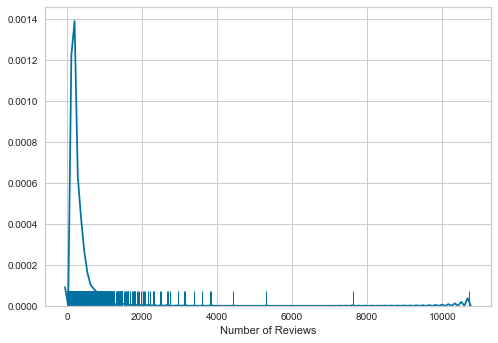

In [788]:
sns.distplot(df_restaurants['Number of Reviews'],hist=False, rug=True)

Text(0.5, 1.0, 'Review distribution before Normalization')

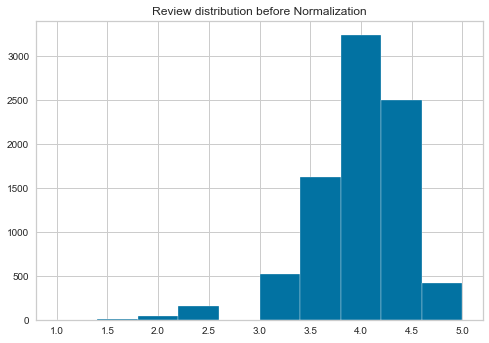

In [789]:
plt.hist(df_restaurants['Rating'])
plt.title('Review distribution before Normalization')

we do the normalization and try again

25 is a magic number which in this method of mormalization gives the largest weighted review under 100

In [790]:
df_restaurants = df_restaurants[df_restaurants['Number of Reviews'] > 2]

In [791]:
R = df_restaurants['Rating']
m = df_restaurants['Number of Reviews'].min()
C = df_restaurants['Rating'].min()
v = df_restaurants['Number of Reviews']

norm = (v/(v+m))*R + (m/(v+m))*C

Text(0.5, 1.0, 'Review Distribution after Normalization')

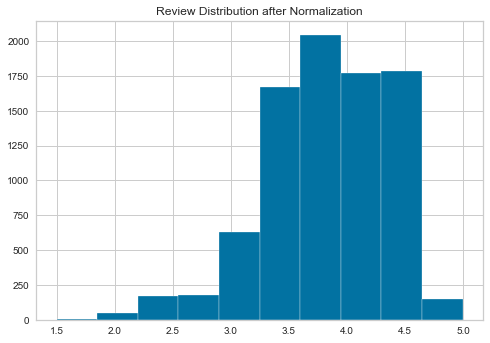

In [792]:
plt.hist(norm)
plt.title('Review Distribution after Normalization')

In [793]:
df_restaurants['Review'] = norm.round(2)
df_restaurants.head()

,Name,Rating,Price Range,Number of Reviews,Review
0,La Meduse,5.0,Moderate,178.0,4.94
1,Le Cappiello,5.0,Moderate,208.0,4.95
2,ASPIC,5.0,High,427.0,4.98
3,Les Apotres de Pigalle,5.0,Moderate,1152.0,4.99
4,Epicure,5.0,High,2305.0,5.00


In [794]:
df_restaurants = df_restaurants.drop(columns=['Rating', 'Number of Reviews'])
df_restaurants.head()

,Name,Price Range,Review
0,La Meduse,Moderate,4.94
1,Le Cappiello,Moderate,4.95
2,ASPIC,High,4.98
3,Les Apotres de Pigalle,Moderate,4.99
4,Epicure,High,5.00


In [795]:
df_restaurants.shape

(8447, 3)

## Part 2: Using Foursquare to get restaurants in each arrondissement

Foursquare credentials

In [796]:
CLIENT_ID = '4B04XQ1N4TVYTAWAGPRRYQITQGVWQALT1SOBPH3CSSSV0HNY' # your Foursquare ID
CLIENT_SECRET = '4HYWBMHSPGOS2CLEHPY4AWZDMGFJJNKKJM0E5JHPHXOANUHC' # your Foursquare Secret
VERSION = '20190519' # Foursquare API version

define a function that fetch data from the API

In [932]:
def getNearbyVenues(names, latitudes, longitudes, radius=2300, LIMIT=150000):
    
    venues_list=[]
    food = '4d4b7105d754a06374d81259'  # catagory for food
    intent = 'browse'
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            intent,
            radius, 
            LIMIT,
            food
        )
        
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']
        ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

define a dataframe for restaurants based on arrondissement

In [933]:
df_venues = getNearbyVenues(names = df_paris['name'],
                                  latitudes = df_paris['latitude'],
                                 longitudes = df_paris['longitude'])
df_venues.head()

Louvre
Bourse
Temple
Hôtel-de-Ville
Panthéon
Luxembourg
Palais-Bourbon
Élysée
Opéra
Entrepôt
Popincourt
Reuilly
Gobelins
Observatoire
Vaugirard
Passy
Batignolles-Monceau
Buttes-Montmartre
Buttes-Chaumont
Ménilmontant


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Louvre,48.8625627018,2.33644336205,Café de Flore,48.853997,2.332646
1,Louvre,48.8625627018,2.33644336205,Hard Rock Cafe,48.871944,2.341604
2,Louvre,48.8625627018,2.33644336205,Les Deux Magots,48.853999,2.333160
3,Louvre,48.8625627018,2.33644336205,Café Marly,48.861740,2.335646
4,Louvre,48.8625627018,2.33644336205,Angelina,48.865090,2.328443


In [934]:
df_venues.shape

(986, 6)

## Part 3: Combine dataframes for the final dataframe to analyze

merge michelin starred restaurants with details to add a label called "michelin"

In [935]:
df_detail = pd.merge(df_michelin, df_restaurants, how='right')
df_detail['Michelin'] = np.where(df_detail['Star']>0, 'yes', 'no')
df_detail = df_detail.drop('Star',1)
df_detail.head()

,Name,Price Range,Review,Michelin
0,Le Cinq,High,4.50,yes
1,Pierre Gagnaire,High,4.49,yes
2,Le Clarence,High,4.43,yes
3,Le Gabriel,High,4.47,yes
4,Maison Rostang,High,4.48,yes


merge restaurant names with details

In [936]:
df_parisCuisine = pd.merge(df_venues, df_detail, how='inner', left_on='Venue', right_on='Name')
df_parisCuisine.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Name,Price Range,Review,Michelin
0,Louvre,48.8625627018,2.33644336205,Brasserie Les Deux Palais,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
1,Bourse,48.8682792225,2.34280254689,Brasserie Les Deux Palais,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
2,Temple,48.86287238,2.3600009859,Brasserie Les Deux Palais,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
3,Hôtel-de-Ville,48.8543414263,2.35762962032,Brasserie Les Deux Palais,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
4,Panthéon,48.8444431505,2.35071460958,Brasserie Les Deux Palais,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no


In [937]:
df_parisCuisine.shape

(250, 10)

In [938]:
df_parisCuisine = df_parisCuisine.drop('Venue',1)
df_parisCuisine.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Name,Price Range,Review,Michelin
0,Louvre,48.8625627018,2.33644336205,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
1,Bourse,48.8682792225,2.34280254689,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
2,Temple,48.86287238,2.3600009859,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
3,Hôtel-de-Ville,48.8543414263,2.35762962032,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no
4,Panthéon,48.8444431505,2.35071460958,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no


In [939]:
df_parisCuisine.shape

(250, 9)

## Part 4: Data Visualization

we first look at the rating of restaurants in different arrondissements

Text(0.5, 0, 'Arrondissement')

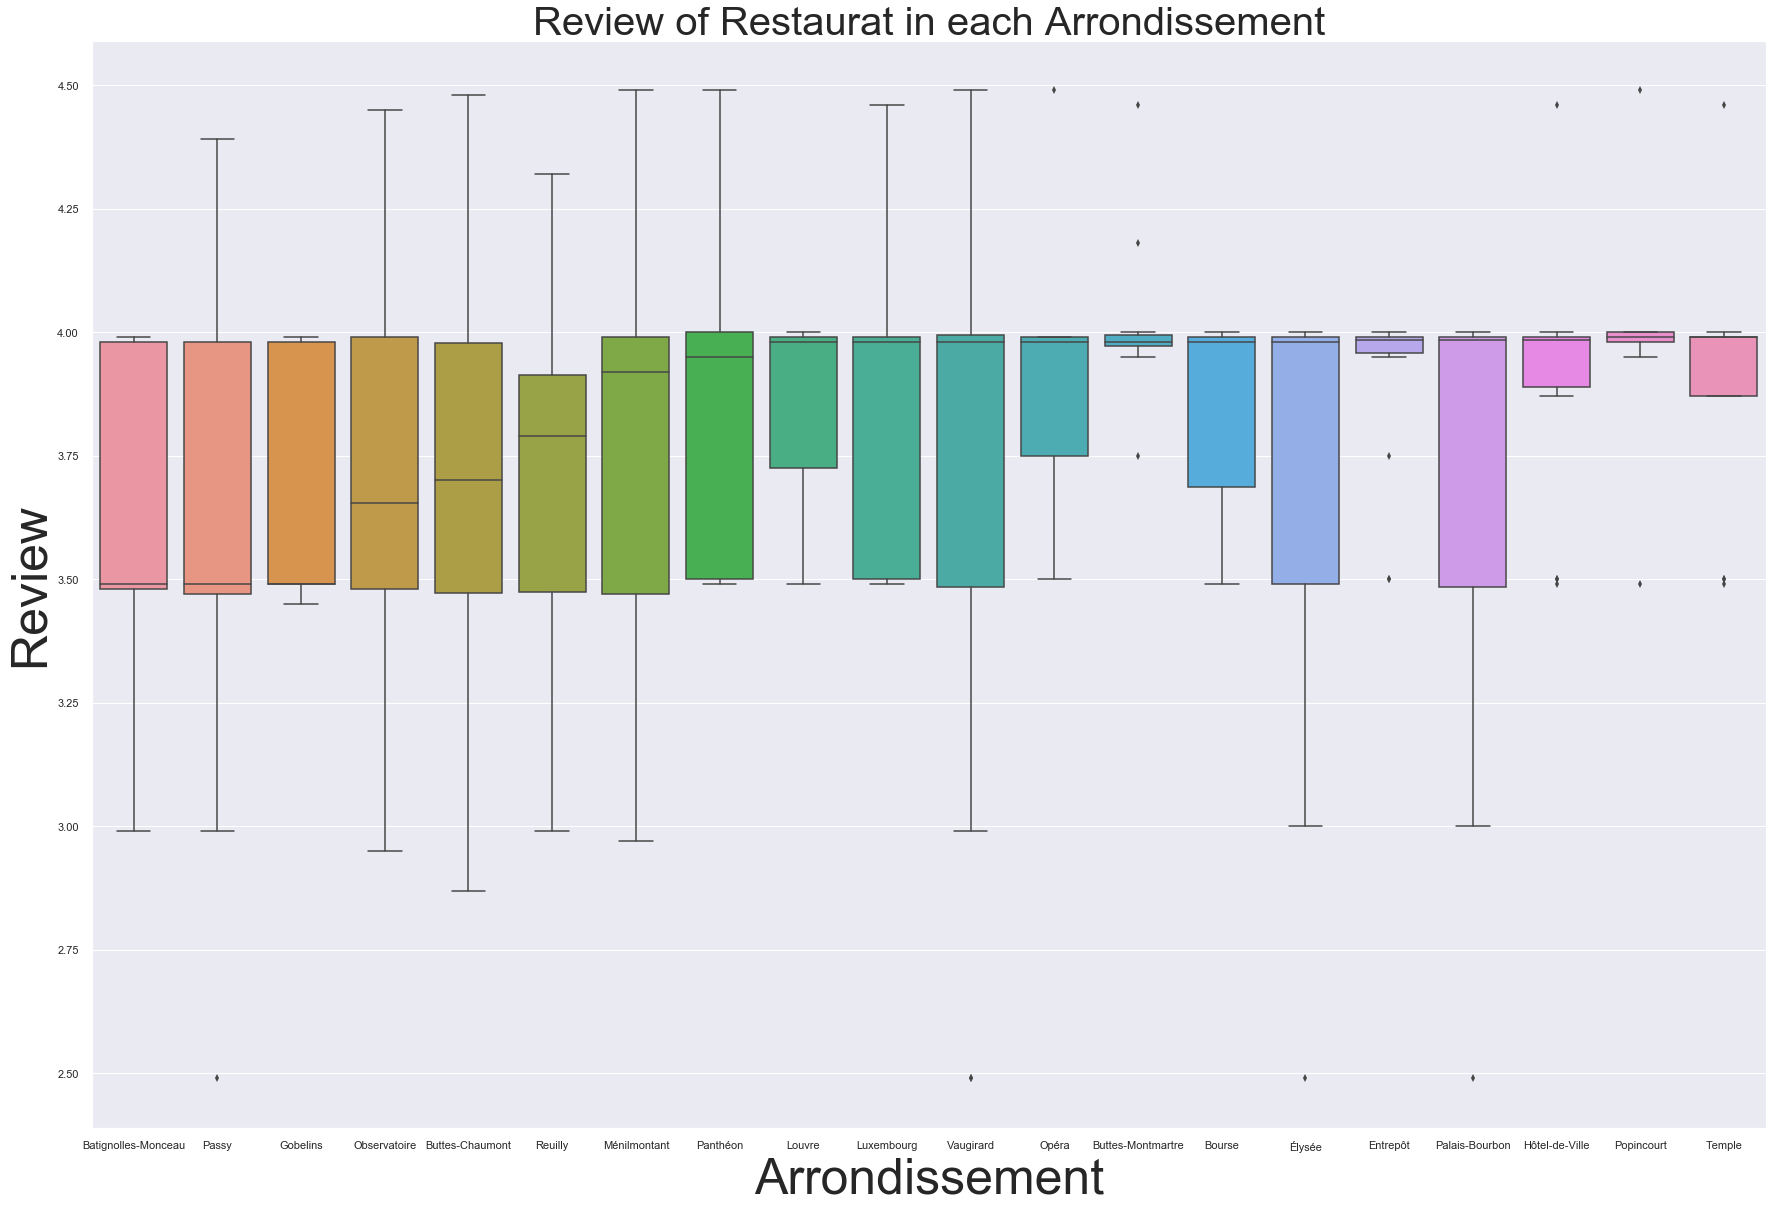

In [940]:
median_review = df_parisCuisine.groupby(['Neighborhood'])['Review'].median().reset_index().sort_values(by='Review')

sns.set(rc={'figure.figsize':(30,20),"font.size":30,"axes.titlesize":40,"axes.labelsize":50})
ax = sns.boxplot(data=df_parisCuisine[['Neighborhood', 'Review']], x = 'Neighborhood', y = 'Review', order=median_review['Neighborhood'])
ax.set_title('Review of Restaurat in each Arrondissement')
ax.set_xlabel('Arrondissement')

In [941]:
median_review['Review'].head()


0     3.490
14    3.490
5     3.490
10    3.655
2     3.700
Name: Review, dtype: float64

now let's look at the percentage of michelin starred restaurants in each arrondissement

Text(0.5, 1.0, 'Percentage of Michelin starred restaurant')

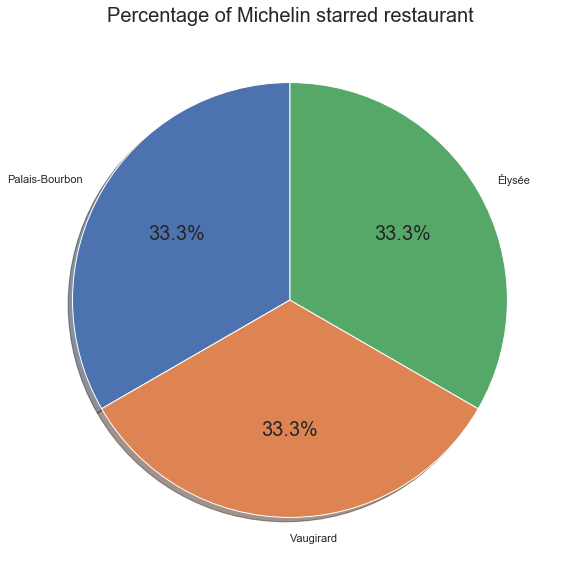

In [942]:
michelin_perc_df = df_parisCuisine[df_parisCuisine['Michelin'] == 'yes']
michelin_perc_df = michelin_perc_df[['Neighborhood', 'Michelin']]
michelin_perc_df = michelin_perc_df.groupby(['Neighborhood'],as_index=False).count()

sns.set(rc={'figure.figsize':(30,20),"font.size":20,"axes.titlesize":20,"axes.labelsize":60})
ax = michelin_perc_df['Michelin'].plot(kind='pie',
                            figsize=(10, 10),
                            autopct='%1.1f%%', 
                            #fontsize=10,
                            startangle=90,    
                            shadow=True,       
                            labels=michelin_perc_df['Neighborhood']
                            )

ax.set_ylabel('')
ax.set_title('Percentage of Michelin starred restaurant')

## Part 5 Clustering for Restaurant Data

### 5.1 Binning rating

In [944]:
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
df_binned = np.searchsorted(bins, df_parisCuisine['Review'].values)
df_parisCuisine['Rate'] = df_binned
df_parisCuisine.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Name,Price Range,Review,Michelin,Rate
0,Louvre,48.8625627018,2.33644336205,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no,7
1,Bourse,48.8682792225,2.34280254689,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no,7
2,Temple,48.86287238,2.3600009859,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no,7
3,Hôtel-de-Ville,48.8543414263,2.35762962032,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no,7
4,Panthéon,48.8444431505,2.35071460958,48.855167,2.346045,Brasserie Les Deux Palais,Moderate,3.49,no,7


### 5.2 Re-encode dataset for clustering

In [945]:
df_parisCluster = df_parisCuisine[['Neighborhood', 'Price Range', 'Michelin', 'Rate']]
df_parisCluster.head()

,Neighborhood,Price Range,Michelin,Rate
0,Louvre,Moderate,no,7
1,Bourse,Moderate,no,7
2,Temple,Moderate,no,7
3,Hôtel-de-Ville,Moderate,no,7
4,Panthéon,Moderate,no,7


In [958]:
paris_onehot = pd.get_dummies(df_parisCluster[['Price Range', 'Michelin', 'Rate']])
paris_onehot['Neighborhood'] = df_parisCluster['Neighborhood']

paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped

,Neighborhood,Rate,Price Range_High,Price Range_Low,Price Range_Moderate,Michelin_no,Michelin_yes
0,Batignolles-Monceau,7.333333,0.222222,0.000000,0.777778,1.000000,0.000000
1,Bourse,7.750000,0.083333,0.083333,0.833333,1.000000,0.000000
2,Buttes-Chaumont,7.500000,0.000000,0.100000,0.900000,1.000000,0.000000
3,Buttes-Montmartre,8.200000,0.000000,0.000000,1.000000,1.000000,0.000000
4,Entrepôt,7.888889,0.055556,0.055556,0.888889,1.000000,0.000000
5,Gobelins,7.400000,0.000000,0.200000,0.800000,1.000000,0.000000
6,Hôtel-de-Ville,7.857143,0.071429,0.071429,0.857143,1.000000,0.000000
7,Louvre,7.727273,0.090909,0.090909,0.818182,1.000000,0.000000
8,Luxembourg,7.769231,0.153846,0.076923,0.769231,1.000000,0.000000
9,Ménilmontant,7.666667,0.000000,0.095238,0.904762,1.000000,0.000000


In [947]:
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)
paris_grouped_clustering.shape

(20, 6)

### 5.3 Determine k for k-means

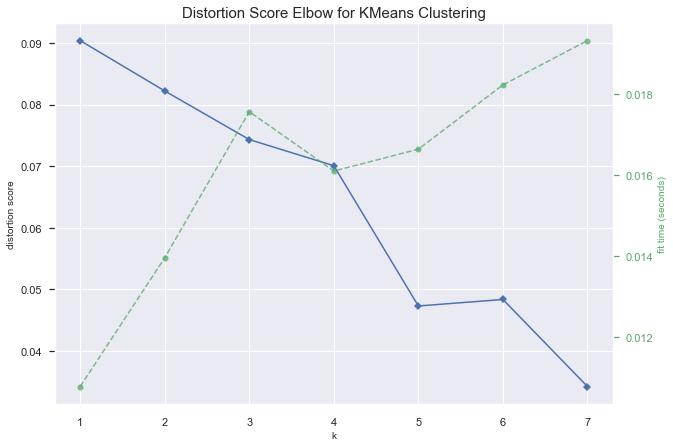

In [955]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
sns.set(rc={'figure.figsize':(10,7),"font.size":20,"axes.titlesize":15,"axes.labelsize":10})
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(paris_grouped_clustering)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

let's take k=5

In [956]:
kclusters = 5

### Clustering the data

In [959]:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

paris_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

paris_grouped

,Cluster Labels,Neighborhood,Rate,Price Range_High,Price Range_Low,Price Range_Moderate,Michelin_no,Michelin_yes
0,3,Batignolles-Monceau,7.333333,0.222222,0.000000,0.777778,1.000000,0.000000
1,4,Bourse,7.750000,0.083333,0.083333,0.833333,1.000000,0.000000
2,1,Buttes-Chaumont,7.500000,0.000000,0.100000,0.900000,1.000000,0.000000
3,2,Buttes-Montmartre,8.200000,0.000000,0.000000,1.000000,1.000000,0.000000
4,4,Entrepôt,7.888889,0.055556,0.055556,0.888889,1.000000,0.000000
5,1,Gobelins,7.400000,0.000000,0.200000,0.800000,1.000000,0.000000
6,4,Hôtel-de-Ville,7.857143,0.071429,0.071429,0.857143,1.000000,0.000000
7,4,Louvre,7.727273,0.090909,0.090909,0.818182,1.000000,0.000000
8,4,Luxembourg,7.769231,0.153846,0.076923,0.769231,1.000000,0.000000
9,1,Ménilmontant,7.666667,0.000000,0.095238,0.904762,1.000000,0.000000


In [960]:
paris_merged = pd.merge(paris_grouped, df_parisCuisine, on='Neighborhood')
paris_merged.head()

,Cluster Labels,Neighborhood,Rate_x,Price Range_High,Price Range_Low,Price Range_Moderate,Michelin_no,Michelin_yes,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Name,Price Range,Review,Michelin,Rate_y
0,3,Batignolles-Monceau,7.333333,0.222222,0.0,0.777778,1.0,0.0,48.887326522,2.30677699057,48.882601,2.337390,Bouillon Pigalle,Moderate,3.95,no,8
1,3,Batignolles-Monceau,7.333333,0.222222,0.0,0.777778,1.0,0.0,48.887326522,2.30677699057,48.881950,2.334456,Pink Mamma,Moderate,3.98,no,8
2,3,Batignolles-Monceau,7.333333,0.222222,0.0,0.777778,1.0,0.0,48.887326522,2.30677699057,48.871611,2.301305,Le Fouquet's,High,3.99,no,8
3,3,Batignolles-Monceau,7.333333,0.222222,0.0,0.777778,1.0,0.0,48.887326522,2.30677699057,48.869693,2.302115,Al Ajami,High,3.48,no,7
4,3,Batignolles-Monceau,7.333333,0.222222,0.0,0.777778,1.0,0.0,48.887326522,2.30677699057,48.883656,2.320595,Mamma Primi,Moderate,3.98,no,8


In [1011]:
# create map
map_clusters = folium.Map(location=[48.864716, 2.349014], zoom_start=12, tiles='cartodbpositron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for i in df_paris_raw['Geometry']:
    folium.GeoJson(i).add_to(map_clusters)
    
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Neighborhood Latitude'], paris_merged['Neighborhood Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):

    label = folium.Popup(str(cluster), parse_html=False)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster-1],
        popup=label,
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
       
map_clusters

In [1009]:
for i in range(5):
    print("------------ cluster {} --------------".format(i+1))
    name = paris_merged.loc[paris_merged['Cluster Labels'] == i]['Name']
    detail = pd.merge(name, df_restaurants)
    print(detail)

------------ cluster 1 --------------
                Name Price Range  Review
0         Le Nemours    Moderate    3.98
1         Le Nemours    Moderate    3.98
2         Buddha Bar        High    3.50
3         Buddha Bar        High    3.50
4          Le Fumoir    Moderate    3.99
5            Carette    Moderate    3.99
6            Carette    Moderate    3.99
7       Chez Francis    Moderate    3.00
8       Chez Francis    Moderate    3.00
9     Le Jules Verne        High    4.00
10    Le Jules Verne        High    4.00
11      Le Fouquet's        High    3.99
12      Le Fouquet's        High    3.99
13     Monsieur Bleu        High    3.99
14     Monsieur Bleu        High    3.99
15   Le Grand Corona    Moderate    2.49
16   Le Grand Corona    Moderate    2.49
17     Noura Marceau    Moderate    3.48
18     Noura Marceau    Moderate    3.48
19  Bouillon Pigalle    Moderate    3.95
20        Pink Mamma    Moderate    3.98
------------ cluster 2 --------------
                      